In [1]:
from music21 import converter, instrument, note, chord, midi
import glob

import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm
import os
from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Lambda, Layer,Flatten, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose, LSTM
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense
from music21 import instrument, note, stream, chord
import shutil
import collections
from collections import *
from keras import optimizers
import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from sklearn.utils import class_weight
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from os.path import isfile, join
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage import morphology
from keras.utils import np_utils

from skimage import filters
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

Using TensorFlow backend.


https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [4]:
def printChord(c):
    print([x.nameWithOctave for x in c.pitches])
    print('PitchedCommonName: %s, root %s, intervalVector %s, normalOrder % ' % 
          (c.pitchedCommonName, c.root(), c.intervalVector, c.normalOrder))
    c.show()
    
def printNote(f):
    
    if f.name == 'rest':
        st = f.name
    else:
        st = f.name + str(f.step) + ' ' + str(f.octave) + ' ' +  str(f.pitch.french) + ' ' + str(f.pitch) + ' ' + str(f.pitch.frequency)
        if f.pitch.accidental:
            st = st + ' ' + f.pitch.accidental.name + ' -extra semi-tones:' + f.pitch.accidental.alter
#     print(st)
    f.addLyric(st)
    return f.show()

def printPitch(p):
    print(p, p.nameWithOctave, p.french, p.octave, p.frequency)
    if p.accidental:
        print(p.accidental, p.accidental.name, '-extra semi-tones: ',p.accidental.alter)

In [6]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.i = self.i+1
        
        if self.i%5 != 0:
            return
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        ax = plt.figure(111)
        self.plotLosses(ax)
        plt.show()

    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.val_losses)), self.val_losses, label="val loss")
        # ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
basicLossPlot = PlotLosses()

In [7]:
from music21 import corpus

In [32]:
notes = []
count = 0
for i in tqdm(corpus.getComposer('bach', 'mxl')):
    s = corpus.parse(i)
    lastwasrest = False
#     print('parts ', len(s.parts))
    for p in s.parts:
#         print('notesAndRests ', len(p.recurse().notesAndRests))
        for element in p.recurse().notesAndRests:
#             print('element : ', element, end='')
            duration = int(element.duration.quarterLength *4)
            duration = min(16,max(1,duration)) # don't want longer than whole or shorter than 16th
            ch = ''
            if isinstance(element, note.Rest):
                nn = 0
                if lastwasrest == True:
                    continue # no need for multiple rests in this scenario
                lastwasrest = True
            elif isinstance(element, note.Note):
                lastwasrest = False
                nn = int(element.pitch.midi)+0
            elif isinstance(element, chord.Chord):
                lastwasrest = False
                nn = int(element.root().midi)+0
                ch = '.'.join(element.intervalVectorString) # only add the extra notes as delta

    #         notes.append(nn)
    #         notes.append([int(nn), int(duration), ch])
            notes.append([int(nn), int(duration)])
#     print('.', end='')
    count = count+1
#     if count == 10:
#         break
notes = np.vstack(notes)
notes.shape

100%|████████████████████████████████████████████████████████████████████████████████| 403/403 [01:15<00:00,  4.48it/s]


(128046, 2)

In [33]:
np.unique(notes.T[0])

array([ 0, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 88])

In [34]:
sequence_length = 100
n_vocab = 128
n_duration = 16

In [36]:
chordlist = np.unique(notes[:,2])
chordlist

IndexError: index 2 is out of bounds for axis 1 with size 2

In [46]:
notes[:,0]

array([65, 67, 60, ..., 43, 50, 43])

In [52]:
nn_inout = np.zeros((len(notes), n_vocab+n_duration))

nn_inout[np.arange(len(notes)),notes[:,0]] = 1
nn_inout[np.arange(len(notes)),n_vocab+notes[:,1]-1] = 1

np.unique(nn_inout, return_counts=True)

nn_inout.shape
nn_inout[0]

(array([ 0.,  1.]), array([18182532,   256092], dtype=int64))

(128046, 144)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

# Second Model, PC

In [53]:
lookback = 32

In [54]:
from keras.layers import Concatenate

In [55]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dropout(0.3)(x)
x = Dense(nn_inout.shape[1])(x)
a1 = Activation('softmax')(Lambda(lambda z : z[:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 144)       0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32, 256)       410624      input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 256)       0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 32, 512)       1574912     dropout_1[0][0]                  
___________________________________________________________________________________________

In [76]:
print('all data', nn_inout.shape)
print('lookback', lookback)
print('train', nn_inout[:-lookback].shape)
print('to predict', nn_inout[lookback:].shape)

all data (128046, 144)
lookback 32
train (128014, 144)
to predict (128014, 144)


In [74]:
128046 % 32

14

In [65]:
a = [[1, 2], [3, 4]]
a
np.pad(a, ((1, 2), (3, 4)), 'constant', constant_values=(0))

[[1, 2], [3, 4]]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0, 0, 0],
       [0, 0, 0, 3, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [59]:
# nn_inout.shape
(0,lookback-nn_inout.shape[0]%lookback)

(0, 18)

In [79]:
# Add '0' at the end to make sure it fits blocks of 32
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2.shape
nn_inout2 = nn_inout2.reshape(-1, lookback, 144)
nn_inout2.shape


(128064, 144)

(4002, 32, 144)

In [71]:
# check what the training data is compared to the thing to predict
i = 43
ss = predtostream(nn_inout2[i,:,:])
nn = predbitfieldtonote(nn_inout2[i+1,0,:])
nn.color = 'red'
ss.append(nn)
ss.show()
print('ambitus:', ss.analyze('ambitus').semitones)

ambitus: 21


In [72]:
basicLossPlot = PlotLosses()


In [81]:
nn_inout2[:-1,:,:].shape
nn_inout2[1:,0,:].shape

(4001, 32, 144)

(4001, 144)

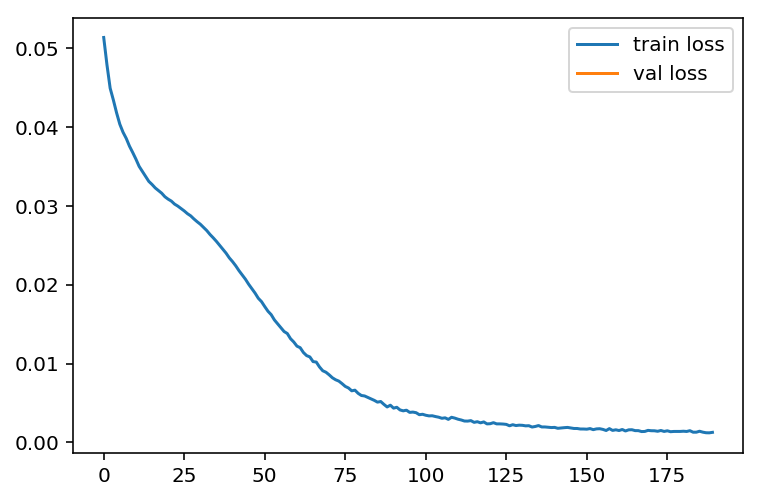

20174/20174 [==============================] - 3s - loss: 0.0013     
Epoch 191/2000
20174/20174 [==============================] - 3s - loss: 0.0013     
Epoch 192/2000
 3072/20174 [===>..........................] - ETA: 3s - loss: 0.0013

KeyboardInterrupt: 

In [434]:
model.fit(nn_inout2[:-1,:,:], nn_inout2[1:,0,:], epochs=2000, batch_size=1024, callbacks=[basicLossPlot])

# End of note+duration train

In [67]:
def predbitfieldtonote(pred):
    no = np.argmax(pred[:n_vocab])
    du = np.argmax(pred[n_vocab:])
    
    if no==0:
        n = note.Rest()
        n.duration.quarterLength = (du+1)/4
    else:
        n = note.Note()
        n.pitch.midi=no
        n.duration.quarterLength = (du+1)/4
    return n

def predtostream(pred):
    s = stream.Stream()
    for i in range(len(pred)):
        n = predbitfieldtonote(pred[i])
        s.append(n)
    return s

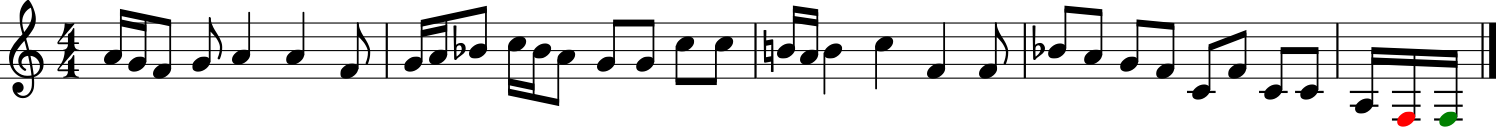

In [435]:
t = 49
s = predtostream(nn_inout2[t])
n = predbitfieldtonote(model.predict(nn_inout2[t:t+1,:,:])[0])
n.color='red'
s.append(n)
c = predbitfieldtonote(nn_inout2[t+1,0,:])
c.color='green'
s.append(c)
s.show()

In [436]:
# create a seed and predict stuff
seed = nn_inout2[33:34,:,:]
print(seed.shape)
# seed = np.zeros((1,32,144))

inp = seed
for i in range(128):
    p = model.predict(inp[:,-lookback:,:])
    inp = np.concatenate([inp,p[newaxis,:,:]], axis=1)
    print('.', end='')
    
# outp = inp
outp = inp[:,lookback:,:] # remove the seed
print(outp.shape)

(1, 32, 144)
................................................................................................................................(1, 128, 144)


In [437]:
output_notes = []
s = stream.Stream()
for i in range(len(outp[0])):
    n = predbitfieldtonote(outp[0,i])
    s.append(n)

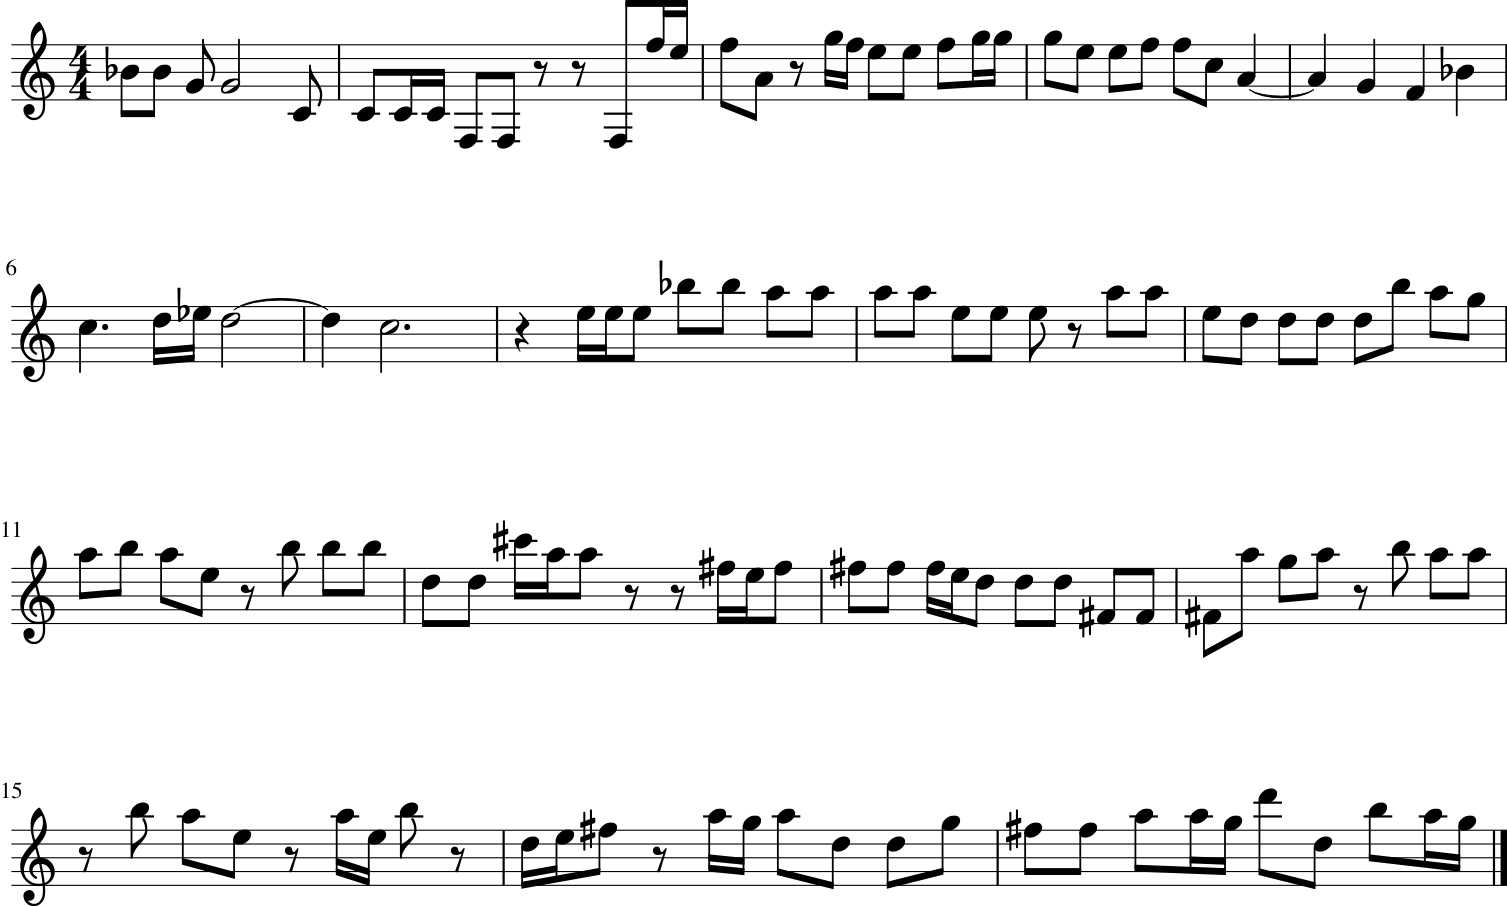

In [438]:
s.show()

In [439]:
s.write('midi', fp=f'output/test_output{datetime.now().strftime("%Y%m%d%H%M%S")}.mid')

'output/test_output20180306100728.mid'

In [99]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)   
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=200, batch_size=64, callbacks=callbacks_list)

Epoch 1/200
9206/9206 [==============================] - 24s - loss: 3.4870    
Epoch 2/200
9206/9206 [==============================] - 24s - loss: 3.4281    
Epoch 3/200
9206/9206 [==============================] - 24s - loss: 3.4038    
Epoch 4/200
9206/9206 [==============================] - 24s - loss: 3.3644    
Epoch 5/200
9206/9206 [==============================] - 24s - loss: 3.2931    
Epoch 6/200
9206/9206 [==============================] - 24s - loss: 3.2294    
Epoch 7/200
9206/9206 [==============================] - 24s - loss: 3.1667    
Epoch 8/200
9206/9206 [==============================] - 24s - loss: 3.5601    
Epoch 9/200
9206/9206 [==============================] - 24s - loss: 3.6413    
Epoch 10/200
9206/9206 [==============================] - 24s - loss: 3.5867    
Epoch 11/200
9206/9206 [==============================] - 24s - loss: 3.5224    
Epoch 12/200
9206/9206 [==============================] - 24s - loss: 3.4891    
Epoch 13/200
9206/9206 [=============

KeyboardInterrupt: 

In [103]:
model.load_weights('weights-improvement-172-0.0521-bigger.hdf5')
# !ls -atl *bigger*

In [12]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]

print('init', pattern.shape, len(pattern), pattern[0])
pattern = list(pattern.reshape(-1))
prediction_output = []
# generate 500 notes
for note_index in range(50):
    print('.', end ='')
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
#     print('>', pattern.shape, len(pattern), index)
#     pattern = list(pattern.reshape(-1))
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

init (100, 1) 100 [ 0.52666667]
..................................................